In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22})

In [8]:
class NetworkGenerator():
    '''Class defining a network generator'''
    def erdos_renyi(self, nodes = 1000, probability = 0.05, random_state = None):
        '''Creates a network using erdos-renyi method with given number of nodes by randomly connecting pairs

        Args:
            nodes (int): The number of nodes,
            probability (float): The probability of connecting two nodes,
            random_state (int): Random state of the generator

        '''
        random = np.random.RandomState(random_state)
        
        links = [[Node(Node.states['susceptible'], i)] for i in range(nodes)]
        for a in links:
            for b in links:
                if (a != b) and (random.random_sample() < probability) and (a[0] not in b):
                    a.append(b[0])
                    b.append(a[0])
        links = np.array(links)
        return Graph(links)
        
        
    def watts_strogatz(self, nodes, rank, probability, random_state=None):
        '''Creates a network using watts-strogatz method with given number of nodes,
            rank of graph and probability of rewiring each edge
            
        Args:
            nodes (int): The number of nodes,
            rank (int): The rank of graph,
            probability (float): The probability of rewiring each edge,
            random_state (int): Random state of the generator
            
        '''
        if rank % 2 != 0:
            raise Exception('Rank should be even.')
        random = np.random.RandomState(random_state)
        links = [[Node(Node.states['susceptible'], i)] for i in range(nodes)]
        for i, a in enumerate(links):
            for j in range(i + 1, i + rank // 2):
                if j >= nodes:
                    j -= nodes
                a.append(links[j][0])
                links[j].append(a[0])
                if random.random_sample() < probability:
                    a.remove(links[j][0])
                    links[j].remove(a[0])
                    while True:
                        random_node = random.randint(0, len(links))
                        if random_node != i and random_node != i + 1 and random_node != i - 1:
                            break
                    a.append(links[random_node][0])
                    links[random_node].append(a[0])
        links = np.array(links)
        return Graph(links)
        
    def barabasi_albert(self, N = 100, m = 10, random_state = None):
        
        '''Creates a network using barabasi-albert method with given number of nodes
            and number of edges to attach from a new node to existing nodes
            
        Args:
            nodes (int): The number of nodes,
            m (int): The number of edges to attach from a new node to existing nodes,
            random_state (int): Random state of the generator
            
        '''
        
        links = [[Node(Node.states['susceptible'], i)] for i in range(m)]
        
        random = np.random.RandomState(random_state)
        E = 0
        for i, a in enumerate(links):
            #print(i, a)
            for j in range(i + 1, m):
                a.append(links[j][0])
                links[j].append(a[0])
                E += 1
                
        for i in range(m, N):
            links.append([Node(Node.states['susceptible'], i)])
            while len(links[i]) < m:
                while True:
                    random_node = random.randint(0, len(links))
                    if random_node != i and random_node != i + 1 and random_node != i - 1:
                            break
                b = len(links[random_node]) / E
                prob = random.uniform(0,1)
                if b > prob:
                    links[i].append(links[random_node][0])
                    links[random_node].append(links[i][0])
                    E += 1
                    
        return Graph(links)


class Node:
    '''Class defining a node in graph

    Attributes:
        infected (bool): Describes if node is infected or not,
        immune (bool): Describes if node is immune to future infections, 
        index (int): Represents node index
    '''
    states = {'susceptible': 0, 'infected': 1, 'recovered': 2}
    
    def __init__(self, state, index):
        self.state = state
        self.index = index
    
    def __repr__(self):
        return repr(self.index) + ": " + repr({v: k for k, v in self.states.items()}[self.state])

class Graph:
    '''Class defining a graph

    Attributes:
        links (:obj:`list` of :obj:`list` of :obj:`Node`): List of connections between nodes
    '''
    def __init__(self, links):
        self.links = links
        self.susceptible, self.infected, self.recovered = [], [], []
                    
    
    def infect(self, model = 'SI', iterations = 20,
               si_p = 0.01, ir_p = 0.01, is_p = 0.01, rs_p = 0.01, reset = True, random_state = None):
        '''Selects random node as patient zero and performs the infection process among all nodes. New, total and 
        actual cases are stored in appropiate lists.

        Args:
            model (string): The selected model of infection,
            iterations (int): The number of iterations,
            si_p (float): The infection probability,
            ir_p (float): The recover probability,
            new (:obj:`list` of :obj:`int`): The list of new cases,
            total (:obj:`list` of :obj:`int`): The list of total cases,
            actual (:obj:`list` of :obj:`int`): The list of actual cases

        '''
        random = np.random.RandomState(random_state)
        
        if reset == True:
            for node in self.links:
                node[0].state = Node.states['susceptible']
            self.susceptible.clear()
            self.infected.clear()
            self.recovered.clear()
        
        if model == 'SI':
            ir_p = 0
            is_p = 0
            rs_p = 0
        elif model == 'SIS':
            ir_p = 0
            rs_p = 0
        elif model == 'SIR':
            is_p = 0
            rs_p = 0
        elif model == 'SIRS':
            is_p = 0
        else:
            raise Exception('Model is not defined')
        
        
        patient_zero = random.randint(0, len(self.links))
        self.links[patient_zero][0].state = Node.states['infected']
        for i in range(iterations):
            sus, inf, rec = 0, 0, 0
            for node in self.links:
                if node[0].state == Node.states['infected']:
                    if random.random_sample() < ir_p:
                        node[0].state = Node.states['recovered']
                        rec += 1
                        inf -= 1
                    if random.random_sample() < is_p:
                        node[0].state = Node.states['susceptible']
                        sus += 1
                        inf -= 1
                if node[0].state == Node.states['recovered']:
                    if random.random_sample() < rs_p:
                        node[0].state = Node.states['susceptible']
                        sus += 1
                        rec -= 1
                if node[0].state == Node.states['infected']:
                    for neighboor in node:
                        if neighboor != node[0] and \
                            neighboor.state == Node.states['susceptible'] and \
                            random.random_sample() < si_p:
                            neighboor.state = Node.states['infected']
                            inf += 1
                            sus -= 1
                        
            self.susceptible.append(sus)
            self.infected.append(inf)
            self.recovered.append(rec)
            
            self.total_infected = np.cumsum(self.infected)
            self.total_recovered = np.cumsum(self.recovered)
            self.total_susceptible = len(self.links) + np.cumsum(self.susceptible)

In [9]:
ng = NetworkGenerator()
er = ng.erdos_renyi(nodes = 1000, probability = 0.01, random_state = 1)
ws = ng.watts_strogatz(nodes = 1000, rank=20, probability=0.1)
ba = ng.barabasi_albert(N = 1000, m = 10)

In [10]:
er.infect(model = 'SIRS', iterations = 200, random_state = 1)
ws.infect(model = 'SI', iterations = 200, random_state = 1)
ba.infect(model = 'SI', iterations = 200, random_state = 1)

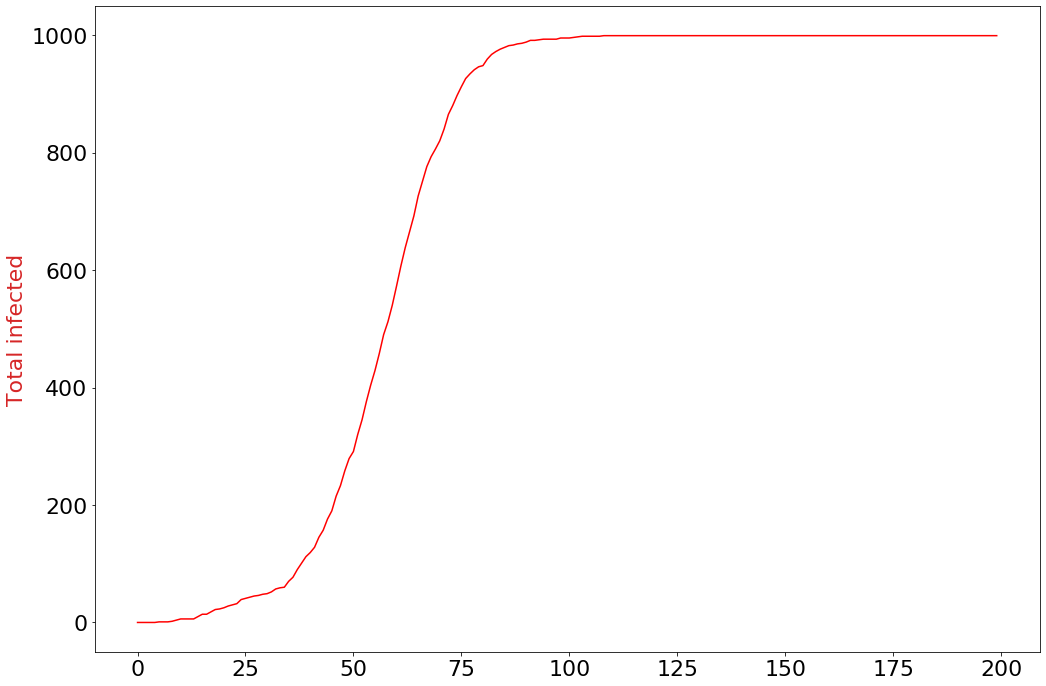

In [11]:
fig, ax =  plt.subplots(figsize=(15,10))
x, y = range(0, len(ws.infected)), [case for case in ws.total_infected]
ax.plot(x, y, color = 'red')
ax.set_ylabel("Total infected", color = 'tab:red')

fig.tight_layout()
plt.show()

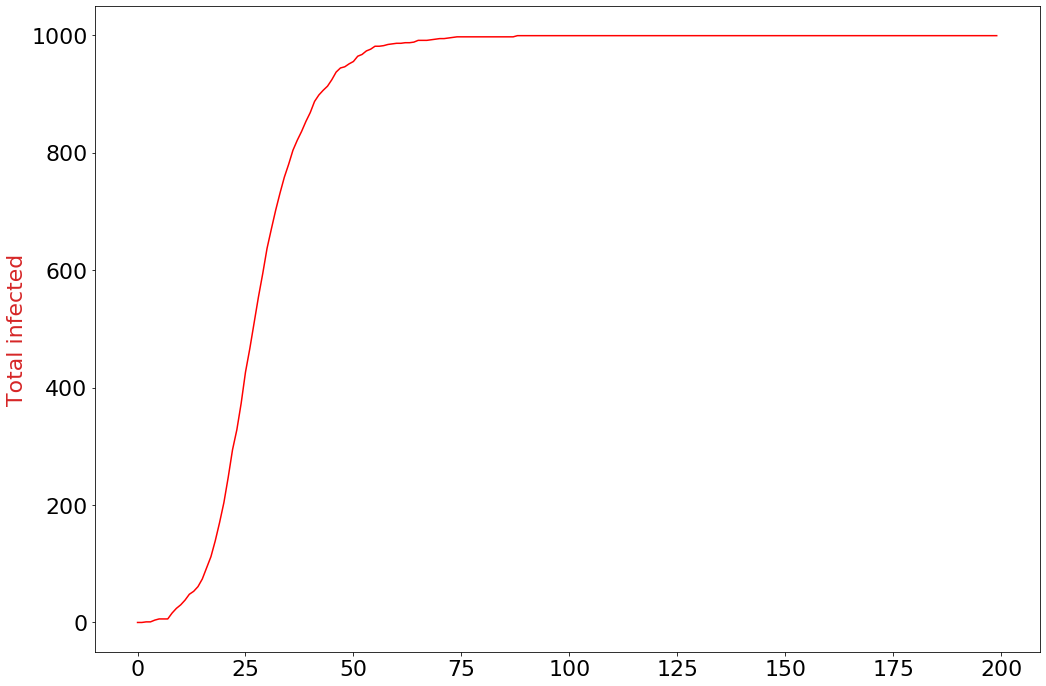

In [12]:
fig, ax =  plt.subplots(figsize=(15,10))
x, y = range(0, len(ba.infected)), [case for case in ba.total_infected]
ax.plot(x, y, color = 'red')
ax.set_ylabel("Total infected", color = 'tab:red')

fig.tight_layout()
plt.show()